# Prediction of number of infractions using 1D CNNs

In [2]:
# Import Libraries
from math import floor

import pandas as pd
import seaborn as sns
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from matplotlib import pyplot
from numpy import mean, std
from sklearn.preprocessing import OrdinalEncoder

In [3]:
# O ficheiro é demasiado grande para o github
df = pd.read_csv('/home/fabio/Downloads/parking-tickets-2017-2019_WDL.csv', sep=';', index_col=0,
                 parse_dates=['EntryDate'])
df

/home/fabio/miniconda3/envs/WDL/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Block,Street,EntryDate,Bylaw,Section,Status,InfractionText,Year,HBLOCK
0,1400,Kingsway,2017-08-23,2849,17.1,IS,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2017,1400 KINGSWAY
1,2100,13th Ave E.,2017-08-26,2849,19.1(H),IS,STOP ON EITHER SIDE OF A LANE WHICH ABUTS COMM...,2017,2100 13TH AVE E
2,2800,Trinity St.,2017-08-26,2849,17.6(B),VA,PARK ON A STREET WHERE A TRAFFIC SIGN RESTRICT...,2017,2800 TRINITY ST
3,200,17th Ave W.,2017-08-27,2849,17.5(B),IS,STOP WITHIN 6 METRES OF THE NEAREST EDGE OF TH...,2017,200 17TH AVE W
4,1900,4th Ave W.,2017-08-19,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1900 4TH AVE W
...,...,...,...,...,...,...,...,...,...
1318730,1000,Smithe St.,2017-04-23,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1000 SMITHE ST
1318731,2500,Yew St.,2017-04-24,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,2500 YEW ST
1318732,600,Seymour St.,2017-04-20,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,600 SEYMOUR ST
1318733,1300,Robson St.,2017-04-22,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1300 ROBSON ST


## Categorical features

In [4]:
def categorical_feature_study(_df, feature, horizontal=False, treshould=0, plot=True):
    df = _df.copy()
    df = df[feature].value_counts().to_frame()

    if treshould > 0:
        df = df[df[feature] >= treshould]

    df = df.reset_index()
    df = df.rename(columns={feature: "Count"})
    df = df.rename(columns={"index": feature})

    if plot:
        fig, ax = pyplot.subplots()  # figsize=(20,15))

        if horizontal:
            sns.barplot(x="Count", y=feature, data=df, ax=ax)
        else:
            sns.barplot(x=feature, y="Count", data=df, ax=ax)

        ax.plot()

    return df

## Encode categorical features

In [5]:
enc = OrdinalEncoder()
df["InfractionText"] = enc.fit_transform(df[["InfractionText"]]).astype(int)

df_infraction = categorical_feature_study(
    df, "InfractionText", horizontal=True, treshould=10000, plot=False)
df_infraction.head()

,InfractionText,Count
0,21,649308
1,37,144750
2,28,106396
3,30,70446
4,91,42980


In [6]:
enc = OrdinalEncoder()
df["Street"] = enc.fit_transform(df[["Street"]]).astype(int)

df_streets = categorical_feature_study(
    df, "Street", horizontal=True, treshould=10000, plot=False)
df_streets.head()

,Street,Count
0,1688,43603
1,1654,31322
2,806,29818
3,1343,28612
4,1348,28438


## Number of infractions per day

In [7]:
holiday_df = pd.read_csv('holidays.csv', sep=',', parse_dates=['date'])
holiday_df.head(5)

,date,holiday
0,2017-01-01,New Year's Day
1,2017-02-20,Family Day
2,2017-04-14,Good Friday
3,2017-05-22,Victoria Day
4,2017-07-03,Canada Day


,Count
count,1089.000000
mean,1210.959596
std,262.500196
min,1.000000
10%,846.200000
20%,970.600000
30%,1075.400000
40%,1160.200000
50%,1241.000000
60%,1309.800000


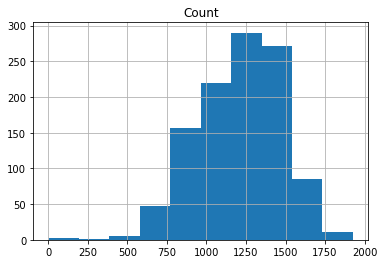

In [8]:
nInfractionsPerDay = df.groupby(['EntryDate']) \
    .count() \
    .rename(columns={'Block': 'Count'})[['Count']] \
    .reset_index()
nInfractionsPerDay["dayOfWeek"] = nInfractionsPerDay.apply(
    lambda row: row.EntryDate.weekday(), axis=1)
nInfractionsPerDay = pd.merge(nInfractionsPerDay, holiday_df, how='left', left_on='EntryDate',
                              right_on='date').drop(columns=['date']).fillna(0, downcast='infer')
nInfractionsPerDay["holiday"] = nInfractionsPerDay.apply(
    lambda row: 0 if row.holiday == 0 else 1, axis=1)

h = nInfractionsPerDay[["Count"]].hist()

nInfractionsPerDay[["Count"]].describe([.1, .2, .3, .4, .5, .6, .7, .8, .9])

## Mapping to categories

- 1 -> Low/No infractions
- 2 -> Some infractions
- 3 -> Average number of infractions
- 4 -> Large number of infractions
- 5 -> Lots of infractions

In [64]:
mapping_dic = {
    1: [0, 970.6],
    2: [970.6, 1160.2],
    3: [1160.2, 1309.8],
    4: [1309.8, 1448.4],
    5: [1448.4, -1]
}


def map_to_cat(num):
    for key, ranges in mapping_dic.items():
        if num >= ranges[0] and (ranges[1] == -1 or num < ranges[1]):
            return key

    print("Negative values not allowed")
    return -1


dfCat = nInfractionsPerDay.copy()
#dfCat["countCat"] = dfCat.apply(lambda row: map_to_cat(row.Count), axis=1)

#del dfCat["Count"]
dfCat

,EntryDate,Count,dayOfWeek,holiday
0,2017-01-02,870,0,0
1,2017-01-03,1487,1,0
2,2017-01-04,1341,2,0
3,2017-01-05,1358,3,0
4,2017-01-06,1413,4,0
...,...,...,...,...
1084,2019-12-27,1155,4,0
1085,2019-12-28,1015,5,0
1086,2019-12-29,903,6,0
1087,2019-12-30,1083,0,0


In [150]:
def generate_features(df, cols, distance=1, count_before=3):
    # Filter rows in which we cannot trace back history
    periodDf = df[df.index-(count_before*distance)>=0].copy()
    # Number of removed elements is the offset for the new df
    n_removed=df.shape[0]-periodDf.shape[0]
    # Add new features based on traced history
    for i in range(0, count_before):
        diff=(i+1)*distance
        for col in cols:
            periodDf[col+"_minus_" + str(diff)]=periodDf.apply(lambda row: df.iloc[int(row.name)-diff][col], axis=1) 
        
    return periodDf

dfFeatures=generate_features(dfCat, ["Count"], distance=7, count_before=6)
dfFeatures=dfFeatures.reset_index()
dfFeatures

,index,EntryDate,Count,dayOfWeek,holiday,Count_minus_7,Count_minus_14,Count_minus_21,Count_minus_28,Count_minus_35,Count_minus_42
0,42,2017-02-13,873,0,0,951,1368,1426,1035,1234,870
1,43,2017-02-14,1451,1,0,1315,1403,1395,1325,1201,1487
2,44,2017-02-15,1516,2,0,974,1661,1462,1442,1255,1341
3,45,2017-02-16,1670,3,0,1074,1439,1365,1326,1228,1358
4,46,2017-02-17,1127,4,0,1318,980,1315,1241,1369,1413
...,...,...,...,...,...,...,...,...,...,...,...
1042,1084,2019-12-27,1155,4,0,1527,1536,1564,1466,1680,1633
1043,1085,2019-12-28,1015,5,0,1499,1394,1178,1261,1454,1477
1044,1086,2019-12-29,903,6,0,1047,731,828,729,857,765
1045,1087,2019-12-30,1083,0,0,1027,696,734,843,781,841


## Prediction model

### Objective
#### Predict count category based on previous count categories/holidays and days of the week

### How we do it
#### Consider the last 4 days of the same day of the week
e.g.
- Atual -> 25 of April
- X     -> 4, 11, 18, 25 of Abril for countCat, holiday and dayOfTheWeek
- Y     -> countCat after one week

In [180]:
from sklearn.preprocessing import OneHotEncoder

def prepare_inputs(X_train, X_test):
    ohe = OneHotEncoder()
    ohe.fit(X_train)
    X_train_enc = ohe.transform(X_train)
    X_test_enc = ohe.transform(X_test)
    return X_train_enc, X_test_enc


def split_df(df, train_size=0.8):
    train_size = floor(df.shape[0]*train_size)

    train = df[:train_size]
    test = df[train_size:]
    
    return train, test

def process_df(train, test):
    trainX = train[dfFeatures.columns[5:]]
    trainX = trainX.to_numpy().reshape(trainX.shape[0], trainX.shape[1], 1)
    trainY = train[["Count"]]
    trainY = trainY.to_numpy().reshape(trainY.shape[0])
    testX = test[dfFeatures.columns[5:]]
    testX = testX.to_numpy().reshape(testX.shape[0], testX.shape[1], 1)
    testY = test[["Count"]]
    testY = testY.to_numpy().reshape(testY.shape[0])
    
    
    return trainX, trainY, testX, testY

train, test = split_df(dfFeatures)
trainX, trainy, testX, testy = process_df(train, test)

In [181]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[0], trainX.shape[1], trainX.shape[2]
    print(n_timesteps)
    print(n_features)
    print(n_outputs)
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_features, n_outputs)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='relu')) # 5 class labels -> 5 softmax neurons
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=False)
    # evaluate model
    _, accuracy = model.evaluate(
        testX, testy, batch_size=batch_size, verbose=0)
    return model, accuracy


def run_experiment(trainX, trainy, testX, testy, repeats=10):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        model, score = evaluate_model(trainX, trainy, testX, testy)
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    m, s = mean(scores), std(scores)
    print ("Mean >> " + str(m))
    print ("Standard deviation >> " + str(s))
    return model

model = run_experiment(trainX, trainy, testX, testy, repeats=3)

837
6
1
>#1: 1618171.625
837
6
1
>#2: 1618171.625
837
6
1
>#3: 50244.777
Mean >> 1095529.3424479167
Standard deviation >> 739127.8042547875


Text(0, 0.5, 'Number of infractions')

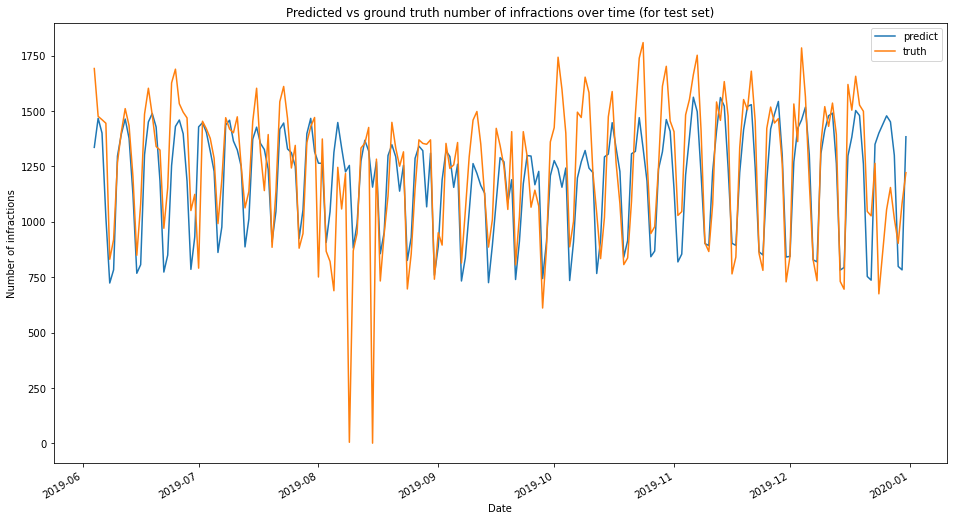

In [184]:
dfPredict = model.predict(testX)

truth=pd.DataFrame(data=testy[:], columns=["truth"])

predict=pd.DataFrame(data=dfPredict.flatten()[:], columns=["predict"])

testDf=pd.concat([predict, truth, test.reset_index()["EntryDate"]], axis=1)

ax=testDf.plot(x="EntryDate", figsize=(16,9), title='Predicted vs ground truth number of infractions over time (for test set)')

ax.set_xlabel("Date")
ax.set_ylabel("Number of infractions")

In [185]:
testDf

,predict,truth,EntryDate
0,1336.103638,1692,2019-06-04
1,1467.323364,1476,2019-06-05
2,1400.738037,1461,2019-06-06
3,1020.404541,1445,2019-06-07
4,723.860718,831,2019-06-08
...,...,...,...
205,1451.220947,1155,2019-12-27
206,1300.275269,1015,2019-12-28
207,798.789612,903,2019-12-29
208,783.168457,1083,2019-12-30
